# Detecting rooftop available surface for installing PV modules in aerial images using Machine Learning
In this notebook we will present the entire pipeline to train a Unet model from a desired data set, evaluate the results and visualize the predictions. We present multiple ways to initialize and train a Unet. All the methods are availble under the section *Training Methods*. Note that in our results *Adaptative Training* provided the best results.

In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import torch
from torch.autograd import Variable
from torchvision.transforms.functional import normalize
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, ConcatDataset
from train.train import *
from tempfile import TemporaryFile
from process_data.normalize import * 

from model.unet import *
from loss.loss import *
from process_data.data_loader import *
from hyperparameters.select_param import *
from process_data.import_test import *
from plots.plots import *

%load_ext autoreload
%autoreload 2

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed_torch() # For reproducibility we set the seed with a seed_torch() method that set the seed in numpy and pytorch

# Loading the Data Set
First we load the data set that we will use for training. Each sample is an image with its mask (label). An image is represented as a 3x250x250 array with each of the 3 color chanel being 250x250 pixels. The asssociated mask is a 250x250 array. Note that we already split the images in train/val/test 80/10/10 in advance to make our reproducibility as clear as possible.

We perform data augmentation and transformation on the training set to counter the low amount of images in our data set. However in the validation set and test set, we only perform transformatio and no augmentation. Again this is to make reproducibility easier. 

In [3]:
folder_path_train_image = 'data/train/images'
folder_path_train_masks = 'data/train/labels'
folder_path_test_image = 'data/test/images'
folder_path_test_masks = 'data/test/labels'
folder_path_val_image = 'data/val/images'
folder_path_val_masks = 'data/val/labels'
folder_path_custom_image = 'data/custom/images'

# Load dataset
train_set = DataLoaderSegmentation(folder_path_train_image,folder_path_train_masks) # 80%
test_set = DataLoaderSegmentation(folder_path_test_image,folder_path_test_masks,augment=False)# 10%, no augmentation
val_set = DataLoaderSegmentation(folder_path_val_image,folder_path_val_masks,augment=False) # 10%, no augmentation
custom_set = DataLoaderSegmentation(folder_path_custom_image, augment=False)

# Init data loader
train_loader = DataLoader(train_set,batch_size=2, shuffle=True ,num_workers=0)
val_loader = DataLoader(val_set,batch_size=2, shuffle=True ,num_workers=0)
test_loader = DataLoader(test_set,batch_size=2 , shuffle=True ,num_workers=0)
custom_loader = DataLoader(custom_set,batch_size=2 , shuffle=True ,num_workers=0)
print(len(train_set),len(test_set),len(val_set),len(custom_set))


420 53 52 1


In [8]:

model = UNet(3,1,False).to(device)

In [9]:
# We may compute the mean and standard deviation of the train loader. This is used either to check if the data loader is normalized, or to compute the mean and std for the normalizer in data_loader.

mean_std(train_loader)

tensor([-0.0083, -0.0094, -0.0106])
tensor([0.9961, 0.9961, 0.9949])


# Training Methods
We now present a certain number of training methods, they all initialize a new Unet model from scratch and train it. Note that this methods should not be used simultaneously. Instead you should choose one of the methods, run it and evaluate its performance.

## Regular training
This is a simple training loop. We can tune the num_epochs, the learning rate and the parameter of the loss function.

In [11]:
# Init training parameters
num_epochs = 50
model = UNet(3,1,False).to(device)
loss_function = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor([4]))#.cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train model
history_train_loss, history_val_loss, history_train_iou, history_val_iou = training_model(train_loader,loss_function,optimizer,model,num_epochs)

In [ ]:
np.random.uniform(-0.1,0.1)

In [ ]:
# Visualize the evolution of the loss and the IoU, either on the train or validation set.
plot_train_val(history_train_loss,history_val_loss,period=25, al_param=False, metric='loss')
plot_train_val(history_train_iou,history_val_iou,period=25, al_param=False, metric='IoU')

## Training with adaptative learning rate
Training with adaptative learning rate is a regular training with an added learning rate scheduler. The task of the scheduler is to change the learning rate depending of the number of epochs. In our testing, the linear learning rate scheduler provided the best results. 



In [ ]:
# Init training parameters
num_epochs = (150)
loss_function = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor([15]).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=0.00008)
# We opted for the linear scheduler. For example, every 60 epochs the learning rate is multiplied by 0.8.
al_param=60
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, al_param, gamma=0.8, last_epoch=-1, verbose=False)

# Train model
history_train_loss, history_val_loss, history_train_iou, history_val_iou = training_model(train_loader,loss_function,optimizer,model,num_epochs,scheduler,val_loader)


In [ ]:
# Visualize the evolution of the loss and the IoU, either on the train or validation set.
plot_train_val(history_train_loss,history_val_loss,period=25, al_param=al_param, metric='loss')
plot_train_val(history_train_iou,history_val_iou,period=25, al_param=al_param, metric='IoU')

## Adaptative Learning
Performs a training on a model over a training data set by doing the following: we first fix the learing rate, then we split the training set into two folds, the model is trained on the first fold then on the second fold. After this has been done, we move on the next learning rate.

Note that this method as no theoritical basis and came up from a flawed cross validation method we did not implemented correctly. However since it was providing good results we decided to clean it and keep it as a training method.

In [ ]:
# Init training parameters
lr_candidates = np.logspace(-1,-2,num=5)
num_epochs = 5
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())
model = UNet(3,1,False).to(device)

# Train model
best_iou, history_iou = adptative_learning(train_set,val_loader,loss_function,best_model,num_epochs,lr_candidates)


# Miscellaneous methods
We may try to identify the best learning rate for our task, either by using a regular grid search algorithm on the learning rate or performing cross validation to have a good estimate of the IoU we may get.

## Find Best Learning Rate
We perform a grid search algorithm on the learning rate, by using a predefined range of learning rates lr and keeping the model that has the best IoU score.

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([25]).cuda())
n_splits = 2
num_epochs = 300
lr = np.logspace(-1,-2,num=5)

best_lr, best_iou = select_hyper_param(train_loader,n_splits,loss_function,num_epochs,lr)

## Cross Validation
We can perform K-fold cross validation on our training set, to have an estimate of the mean iou and accuracy we may hope to achieve. Note that K-Fold CV is not considered as appropriate for CNN parameters tuning, since it is very costly.

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())
n_splits = 2
num_epochs = 10
lr = 0.01

iou_, acc_ = cross_validation(train_dataset=train_set,n_splits, loss_function, num_epochs, lr)

# Export or import a model

## Export a model 
To save a model trained with one of the aforementionned methods, one could use the following cell. The model is save in the *model* folder.

In [ ]:
torch.save(model.state_dict(), 'model/'+input('Name of the model file:')+".pt")

## Import a model 
To import a model, one could use the following cell. The model must be located in the *model* folder. In the command prompt you can for example write *all/batch5loss4_200*

In [4]:
# path = 'models/all/'+input('Name of the model file:')+".pt"
path = 'models/all/batch5_loss4_1000.pt'
model = UNet(3,1,False).to(device)
# model.load_state_dict(torch.load(path))
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

<All keys matched successfully>

# Evaluation of the model
We can evaluate the model to have the mean (IoU, Accuracy) on every data set, and print the number of parameters of the Unet.

In [10]:
print('Train:', test_model(train_loader,model))
print('Val:', test_model(val_loader,model))
print('Test:', test_model(test_loader,model))

In [ ]:
sum(p.numel() for p in model.parameters())

# Visualization of the model
With the model we trained or imported, we can display from the test_loader examples of its prediction.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iou: 0.6071
Accuracy: 0.892032


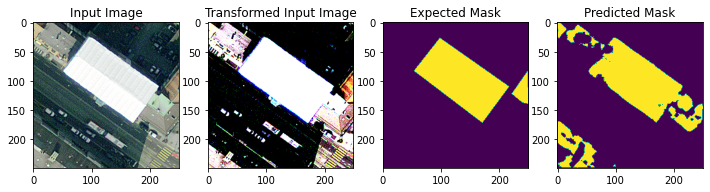

In [11]:
# Get the input, transformed input and prediction made by the model
model.eval()
index_random_sample = int(np.random.random()*len(test_loader.dataset))
(x,y,z) = test_loader.dataset.__getitem__(index_random_sample,show_og=True)
ypred = torch.squeeze(model.predict(torch.unsqueeze(x,0))).cpu().detach().numpy()

# Display all 4 images
fig = plt.figure()
fig.set_size_inches(12, 7, forward=True)
ax1 = fig.add_subplot(1,4,1)
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(1,4,2)
ax2.title.set_text('Transformed Input Image')
ax3 = fig.add_subplot(1,4,3)
ax3.title.set_text('Expected Mask')
ax4 = fig.add_subplot(1,4,4)
ax4.title.set_text('Predicted Mask')

ax1.imshow(z)
ax2.imshow(np.transpose(x.numpy(),(1,2,0)))
ax3.imshow(y)
ax4.imshow(np.around((ypred)))

# Compute IoU and accuracy on prediction and mask
predict_iou = np.around(iou(np.around(ypred),y.numpy()),4)
predict_acc = accuracy(np.around(ypred),y.numpy())
print('Iou:',predict_iou)
print('Accuracy:', predict_acc)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iou: 0.9424
Accuracy: 0.942388638941784


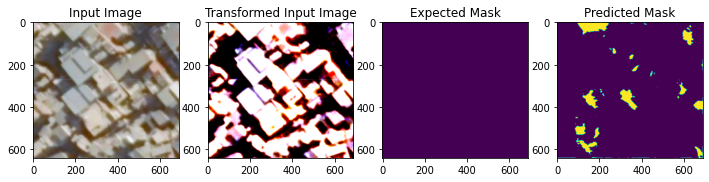

In [12]:
# Get the input, transformed input and prediction made by the model
model.eval()
index_random_sample = int(np.random.random()*len(custom_loader.dataset))
(x,y,z) = custom_loader.dataset.__getitem__(index_random_sample,show_og=True)
ypred = torch.squeeze(model.predict(torch.unsqueeze(x,0))).cpu().detach().numpy()

# Display all 4 images
fig = plt.figure()
fig.set_size_inches(12, 7, forward=True)
ax1 = fig.add_subplot(1,4,1)
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(1,4,2)
ax2.title.set_text('Transformed Input Image')
ax3 = fig.add_subplot(1,4,3)
ax3.title.set_text('Expected Mask')
ax4 = fig.add_subplot(1,4,4)
ax4.title.set_text('Predicted Mask')

ax1.imshow(z)
ax2.imshow(np.transpose(x.numpy(),(1,2,0)))
ax3.imshow(y)
ax4.imshow(np.around((ypred)))

# Compute IoU and accuracy on prediction and mask
predict_iou = np.around(iou(np.around(ypred),y.numpy()),4)
predict_acc = accuracy(np.around(ypred),y.numpy())
print('Iou:',predict_iou)
print('Accuracy:', predict_acc)
